In [671]:
## Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
from typing import Tuple, Dict

import polars as pl

import warnings
warnings.filterwarnings('ignore')

In [672]:
## Configuration and Data Loading (kaggle_evaluation only)
# import kaggle_evaluation.default_inference_server as kdeval
# DATA_DIR = Path('/kaggle/input/hull-tactical-market-prediction')

## Configuration and Data Loading (local version only)
DATA_DIR = Path("01_data")

# Read CSV files from data_path
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH  = DATA_DIR / 'test.csv'

VALIDATION_SIZE = 2700          # days, approx. 30% of data
# RANDOM_SEED = 42

import random
RANDOM_SEED = random.randint(1, 10000)

VOL_MULTIPLIER_LIMIT = 1.2
VOL_WINDOW = 20

def time_split_train_val(df: pd.DataFrame, val_size: int = 2700):
    df = df.sort_values('date_id').reset_index(drop=True)
    train_df = df.iloc[:-val_size].copy()
    val_df   = df.iloc[-val_size:].copy()
    return train_df, val_df

train_raw = pd.read_csv(TRAIN_PATH)
test_raw  = pd.read_csv(TEST_PATH)

# lower column names
train_raw.columns = [c.lower() for c in train_raw.columns]
test_raw.columns  = [c.lower() for c in test_raw.columns]
train_raw.shape, test_raw.shape

((8990, 98), (10, 99))

In [673]:
# main_features = ['m4', 'm11', 'v13', 's2', 'p6', 'm12', 's1', 'v9', 'e17', 'p7'] # from EDA

# # keep only main features in train_raw
# train_p = train_raw[['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns'] + main_features].copy()
# test_p  = test_raw[['date_id'] + main_features].copy()

In [674]:
# train_p.shape

In [675]:
# train_p.head()

In [676]:
# # check for nan in train_p
# train_p.isna().sum()

In [677]:
## Feature Preparation
excluded = {'date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns'}

feature_cols = [c for c in train_raw.columns if c not in excluded]
# feature_cols = [c for c in train_p.columns if c not in excluded]

feature_cols = [c for c in feature_cols if c in test_raw.columns]

In [678]:
feature_cols

['d1',
 'd2',
 'd3',
 'd4',
 'd5',
 'd6',
 'd7',
 'd8',
 'd9',
 'e1',
 'e10',
 'e11',
 'e12',
 'e13',
 'e14',
 'e15',
 'e16',
 'e17',
 'e18',
 'e19',
 'e2',
 'e20',
 'e3',
 'e4',
 'e5',
 'e6',
 'e7',
 'e8',
 'e9',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'm1',
 'm10',
 'm11',
 'm12',
 'm13',
 'm14',
 'm15',
 'm16',
 'm17',
 'm18',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6',
 'm7',
 'm8',
 'm9',
 'p1',
 'p10',
 'p11',
 'p12',
 'p13',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 's1',
 's10',
 's11',
 's12',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 'v1',
 'v10',
 'v11',
 'v12',
 'v13',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9']

In [679]:
def prepare_df(df: pd.DataFrame, median_map: Dict[str, float], feature_cols: list) -> pd.DataFrame:
    """
    Clean and prepare DataFrame by handling missing values intelligently.
    
    Strategy:
    - Use median imputation for numeric columns with some missing values
    - Use zero-fill for columns with very few missing values  
    - Only process existing columns (no synthetic data creation)

    Median is much less sensitive to extreme values (outliers)
    Mean can be heavily skewed by a few very large or very small values
    """
    df = df.copy()
    
    # Only work with columns that actually exist in the DataFrame
    existing_cols = [col for col in feature_cols if col in df.columns]
    
    if not existing_cols:
        return df
    
    # Calculate missing percentages for existing columns
    missing_pct = (df[existing_cols].isnull().sum() / len(df)) * 100
    
    # Categorize columns by missing percentage
    cols_fill_median = missing_pct[(missing_pct > 5) & (missing_pct <= 50)].index.tolist()
    cols_fill_zero = missing_pct[missing_pct <= 5].index.tolist()
    
    # Apply median imputation for moderately missing columns
    if cols_fill_median:
        for col in cols_fill_median:
            median_val = median_map.get(col, df[col].median())
            df[col] = df[col].fillna(median_val)
    
    # Apply zero-fill for low missing columns
    if cols_fill_zero:
        df[cols_fill_zero] = df[cols_fill_zero].fillna(0)
    
    # Ensure all columns are numeric
    for col in existing_cols:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    return df

In [680]:
## Train / Validation Split and Median Imputation
train_df, val_df = time_split_train_val(train_raw, val_size=VALIDATION_SIZE)

median_map = {c: float(train_df[c].median(skipna=True)) if train_df[c].dtype.kind in 'fiu' else 0.0 
              for c in feature_cols}

train_p = prepare_df(train_df, median_map, feature_cols)
val_p   = prepare_df(val_df, median_map, feature_cols)
test_p  = prepare_df(test_raw, median_map, feature_cols)

# Use only the actual feature columns (no synthetic _was_na columns)
final_features = [c for c in feature_cols if c in train_p.columns]
print("Number of features:", len(final_features))

Number of features: 94


In [681]:
# train_p.head()

In [682]:
print(train_p.columns)

Index(['date_id', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'e1',
       'e10', 'e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19',
       'e2', 'e20', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'i1', 'i2', 'i3',
       'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'm1', 'm10', 'm11', 'm12', 'm13',
       'm14', 'm15', 'm16', 'm17', 'm18', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7',
       'm8', 'm9', 'p1', 'p10', 'p11', 'p12', 'p13', 'p2', 'p3', 'p4', 'p5',
       'p6', 'p7', 'p8', 'p9', 's1', 's10', 's11', 's12', 's2', 's3', 's4',
       's5', 's6', 's7', 's8', 's9', 'v1', 'v10', 'v11', 'v12', 'v13', 'v2',
       'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'forward_returns',
       'risk_free_rate', 'market_forward_excess_returns'],
      dtype='object')


In [683]:
final_features

['d1',
 'd2',
 'd3',
 'd4',
 'd5',
 'd6',
 'd7',
 'd8',
 'd9',
 'e1',
 'e10',
 'e11',
 'e12',
 'e13',
 'e14',
 'e15',
 'e16',
 'e17',
 'e18',
 'e19',
 'e2',
 'e20',
 'e3',
 'e4',
 'e5',
 'e6',
 'e7',
 'e8',
 'e9',
 'i1',
 'i2',
 'i3',
 'i4',
 'i5',
 'i6',
 'i7',
 'i8',
 'i9',
 'm1',
 'm10',
 'm11',
 'm12',
 'm13',
 'm14',
 'm15',
 'm16',
 'm17',
 'm18',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6',
 'm7',
 'm8',
 'm9',
 'p1',
 'p10',
 'p11',
 'p12',
 'p13',
 'p2',
 'p3',
 'p4',
 'p5',
 'p6',
 'p7',
 'p8',
 'p9',
 's1',
 's10',
 's11',
 's12',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 'v1',
 'v10',
 'v11',
 'v12',
 'v13',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9']

In [684]:
# # print head(10) for columns 'v13' and 'v13_was_na' to check values
# print(train_p[['v13', 'v13_was_na']].head(10))

In [685]:
# === Bayesian Ridge Training ===
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

# Prepara i dati (usando gli stessi DataFrame)
X_train = train_p[final_features]
y_train = train_p['forward_returns']
X_val   = val_p[final_features]
y_val   = val_p['forward_returns']

# Check for NaN values and handle them
print(f"NaN values in X_train: {X_train.isnull().sum().sum()}")
print(f"NaN values in y_train: {y_train.isnull().sum()}")

# Fill any remaining NaN values
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
X_val = X_val.fillna(0)
y_val = y_val.fillna(0)

# count nan in X_train, y_train, X_val, y_val
print(f"After filling NaN values:")
print(f"NaN values in X_train: {X_train.isnull().sum().sum()}")
print(f"NaN values in y_train: {y_train.isnull().sum()}")
print(f"NaN values in X_val: {X_val.isnull().sum().sum()}")
print(f"NaN values in y_val: {y_val.isnull().sum()}")

NaN values in X_train: 54318
NaN values in y_train: 0
After filling NaN values:
NaN values in X_train: 0
NaN values in y_train: 0
NaN values in X_val: 0
NaN values in y_val: 0


In [686]:
# Crea e allena il modello
model = BayesianRidge()
model.fit(X_train, y_train)

# Valutazione sul validation set
val_pred = model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Validation RMSE: {rmse_val:.6f}")

Validation RMSE: 0.010282


In [687]:
# === Volatility Scaling Calibration (BayesianRidge version) ===
def strategy_stats(returns, exposures):
    """Compute Sharpe and volatility for a given exposure series."""
    strat = exposures * returns
    mean = np.nanmean(strat)
    std  = np.nanstd(strat)
    sharpe = (mean / (std + 1e-9)) * np.sqrt(252)
    vol = std * np.sqrt(252)
    return {'sharpe': sharpe, 'vol': vol}

# Ensure validation data has no NaN values
val_features_clean = val_p[final_features].fillna(0)

# Predict mean and std (Bayesian posterior uncertainty)
val_pred_mean, val_pred_std = model.predict(val_features_clean, return_std=True)

# Define market volatility for scaling reference
market_vol = np.nanstd(train_p['forward_returns']) * np.sqrt(252)
print(f"Market annualized volatility: {market_vol:.4f}")

# We'll use a dynamic confidence weight: confidence = 1 / (1 + std)
confidence = 1 / (1 + val_pred_std)
val_conf_adj = val_pred_mean * confidence  # lower exposure when uncertainty is high

# Grid search for best scaling factor k (Sharpe ratio under vol constraint)
best_k, best_sharpe = 0.1, -1e9
for k in np.linspace(0.01, 5.0, 100):
    exposures = np.clip((k * val_conf_adj), 0, 2)
    stats = strategy_stats(val_p['forward_returns'], exposures)
    if stats['vol'] <= VOL_MULTIPLIER_LIMIT * market_vol and stats['sharpe'] > best_sharpe:
        best_k = k
        best_sharpe = stats['sharpe']

print(f"Chosen scaling factor k={best_k:.3f} | Validation Sharpe={best_sharpe:.2f}")

Market annualized volatility: 0.1698
Chosen scaling factor k=5.000 | Validation Sharpe=0.64


In [688]:
## Test Predictions + Smoothing
test_features_clean = test_p[final_features].fillna(0)
test_pred = model.predict(test_features_clean)

alpha = 0.8
smoothed_allocation = []
prev = 0.0
for x in np.clip(best_k * test_pred, 0, 2):
    s = alpha * x + (1 - alpha) * prev
    smoothed_allocation.append(s)
    prev = s
smoothed_allocation = np.array(smoothed_allocation)

# replace in final submission
submission_df = pd.DataFrame({
    'date_id': test_p['date_id'],
    'prediction': smoothed_allocation  
})
# submission_df.to_csv("submission_br.csv", index=False)
print("Saved submission_br.csv")

Saved submission_br.csv


In [689]:
# Install shap if not already installed: pip install shap
import shap

print("Creating SHAP explainer for Bayesian Ridge model...")

# For linear models like BayesianRidge, we can use the Linear explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_train)

# # Alternative: Use the general Explainer (slower but works for any model)
# explainer = shap.Explainer(model, X_train)
# shap_values = explainer(X_train)

# Get feature importance as mean absolute SHAP values
feature_importance_shap = pd.DataFrame({
'feature': X_train.columns,
'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (SHAP values):")
print(feature_importance_shap.head(20))

# Plot SHAP summary
# shap.summary_plot(shap_values, X_train, show=False)

Creating SHAP explainer for Bayesian Ridge model...

Top 20 Most Important Features (SHAP values):
   feature  importance
50      m4    0.000546
85     v13    0.000514
40     m11    0.000488
73      s2    0.000410
27      e8    0.000401
55      m9    0.000347
20      e2    0.000253
66      p7    0.000244
3       d4    0.000237
22      e3    0.000200
41     m12    0.000192
65      p6    0.000191
58     p11    0.000191
48      m2    0.000180
69      s1    0.000176
67      p8    0.000158
30      i2    0.000148
59     p12    0.000140
61      p2    0.000136
49      m3    0.000131


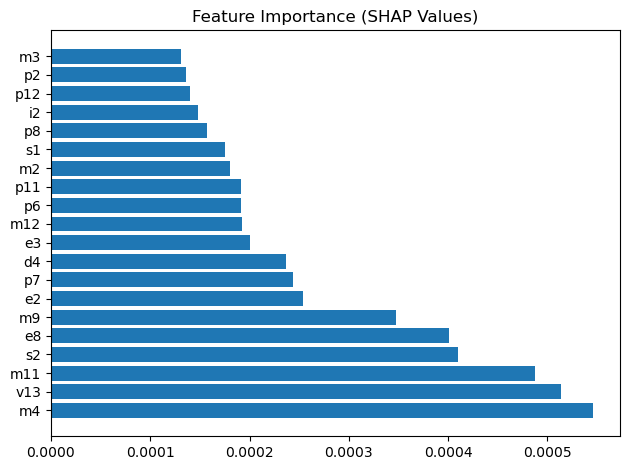

In [690]:
# Show feature importance plot
import matplotlib.pyplot as plt
plt.barh(feature_importance_shap['feature'][:20], feature_importance_shap['importance'][:20])
plt.title("Feature Importance (SHAP Values)")
plt.tight_layout()
plt.show()


Generating detailed SHAP summary plot...


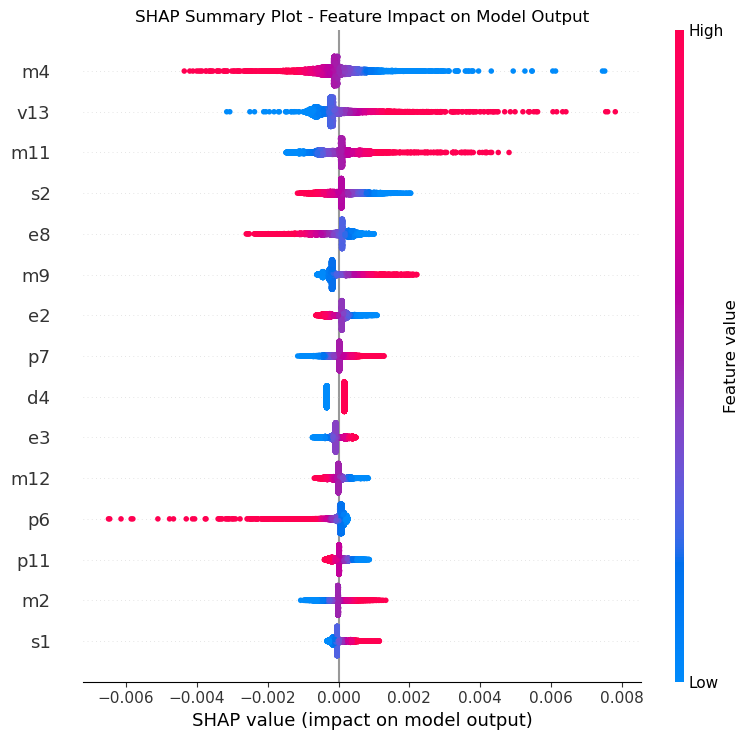

In [691]:
# Optional: Create a more detailed summary plot
print("\nGenerating detailed SHAP summary plot...")
shap.summary_plot(shap_values, X_train, max_display=15, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Model Output")
plt.tight_layout()
plt.show()

In [692]:
# Print model coefficients for comparison
print("\nModel Coefficients (for comparison):")
coef_importance = pd.DataFrame({
'feature': X_train.columns,
'coefficient': model.coef_,
'abs_coefficient': np.abs(model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(coef_importance.head(20))


Model Coefficients (for comparison):
   feature  coefficient  abs_coefficient
50      m4    -0.000809         0.000809
85     v13     0.000639         0.000639
40     m11     0.000606         0.000606
73      s2    -0.000549         0.000549
3       d4     0.000499         0.000499
0       d1     0.000494         0.000494
1       d2     0.000494         0.000494
27      e8    -0.000468         0.000468
65      p6    -0.000411         0.000411
48      m2     0.000394         0.000394
7       d8     0.000375         0.000375
55      m9     0.000358         0.000358
67      p8    -0.000343         0.000343
66      p7     0.000342         0.000342
72     s12     0.000339         0.000339
60     p13    -0.000308         0.000308
93      v9    -0.000291         0.000291
4       d5     0.000285         0.000285
56      p1    -0.000263         0.000263
79      s8     0.000251         0.000251


In [693]:
"""
Kaggle Evaluation Metric:

strategy_returns = risk_free_rate * (1 - position) + position * forward_returns

if position = 0 → invest in risk-free asset,

if position = 1 → invest like the market,

if position = 2 → you are leveraged ×2 on the market.


def score():

strategy_returns = rf * (1 - pos) + pos * fwd_returns

In the code, the calibration seeks the best Sharpe of the portfolio exposed to pos by calculating:

strat = exposures * returns
""";

In [694]:
# # === Kaggle Inference Server Wrapper (BayesianRidge version) ===

# _model = model                     # BayesianRidge fitted model
# _best_k = best_k                   # scaling factor from validation calibration
# _history_returns = list(train_p['forward_returns'].iloc[-VOL_WINDOW:].tolist())

# def predict(pl_df: pl.DataFrame) -> float:
#     """Predict allocation for one timestep (Kaggle competition API)."""
#     global _history_returns
#     # Convert Polars → Pandas
#     pdf = pl_df.to_pandas()
    
#     # Apply same preprocessing
#     pdf_p = prepare_df(pdf, median_map, feature_cols)
#     for f in final_features:
#         if f not in pdf_p.columns:
#             pdf_p[f] = 0.0
    
#     # Convert to NumPy and predict
#     x = pdf_p[final_features].to_numpy()

#     """
#     added standard deviation based confidence adjustment
#     to reduce allocation when uncertainty is high
#     """

#     pred, std = model.predict(x, return_std=True)
    
#     # Compute rolling volatility estimate
#     vol_est = np.std(_history_returns) or 1e-3
#     confidence = 1 / (1 + std)
#     alloc = float(np.clip(_best_k * pred * confidence / (vol_est + 1e-9), 0, 2))
    
#     # Update history (for volatility tracking)
#     if 'lagged_forward_returns' in pl_df.columns:
#         try:
#             _history_returns.append(float(pl_df['lagged_forward_returns'][0]))
#         except:
#             _history_returns.append(0.0)
#     else:
#         _history_returns.append(0.0)
    
#     # Keep only the last VOL_WINDOW entries
#     _history_returns = _history_returns[-VOL_WINDOW:]
#     return alloc

# # Instantiate the Kaggle inference server
# server = kdeval.DefaultInferenceServer(predict)

# if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
#     server.serve()
# else:
#     server.run_local_gateway((str(DATA_DIR),))
